### Imports

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy.random import randn, rand


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "Times New Roman",
})

### Defining Parameters

In [85]:
# Set the initial conditions
q0 = np.pi/4   # initial position
p0 = 0         # initial momentum

L = 1           # Length of the pendulum
m = 1           # Mass of the pendulum
theta = 0       # Angle
g = 9.81        # Acceleration of gravity

# Set the simulation parameters
dt_leap = 0.05     # stepsize
dt_euler = 0.01
t_max = 10.0   # maximum simulation time
m = 1

### Hamiltonian dynamics for pendulum

In [86]:
def hamiltonian_dynamics(t, x): # for pendulum (996) and (997) in optimization
    return np.array([x[1]/(m*L^2), -m*g*L*np.sin(x[0])])

def gradient_potenital_energy(q): 
    return m*g*L*np.sin(q)

#### Leapfrog method

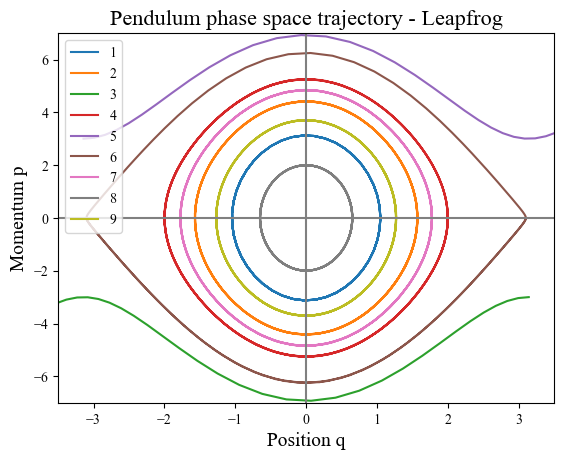

In [108]:
# Define the Leapfrog integrator
def leapfrog(q, p, dt):
    p_half = p - 0.5*dt*gradient_potenital_energy(q)
    q_next = q + dt*p_half
    p_next = p_half - 0.5*dt*gradient_potenital_energy(q_next)
    return q_next, p_next

def generate_trajectory(q0, p0):
    # Initialize the trajectory arrays
    t_leapfrog = np.arange(0, t_max, dt_leap)
    q_leapfrog = np.zeros_like(t_leapfrog)
    p_leapfrog = np.zeros_like(t_leapfrog)

    # Set the initial values
    q_leapfrog[0] = q0
    p_leapfrog[0] = p0

    # Run the simulation using the Leapfrog integrator
    for i in range(1, len(t_leapfrog)):
        q_leapfrog[i], p_leapfrog[i] = leapfrog(q_leapfrog[i-1], p_leapfrog[i-1], dt_leap)

    return q_leapfrog, p_leapfrog

# [-np.pi, 5], [np.pi, -5]
init_conditions = [[np.pi/3, 0], [np.pi/2, 0], [np.pi, -3],  [2, 0], [-np.pi, 3], [3.1, 0], [np.pi/2, 2], [0, 2], [np.pi/3, 2]]
q_leapfrog = []
p_leapfrog = []
legend = []

for i in range(len(init_conditions)):
    q, p = generate_trajectory(init_conditions[i][0], init_conditions[i][1])
    q_leapfrog.append(q)
    p_leapfrog.append(p)

# Plot the trajectory in phase space
for i in range(len(q_leapfrog)):
    plt.plot(q_leapfrog[i], p_leapfrog[i])
    legend.append(str(i+1))

plt.xlabel('Position q', fontsize = 14)
plt.ylabel('Momentum p', fontsize = 14)
plt.xlim((-3.5, 3.5))
plt.ylim((-7, 7))
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')
plt.legend(legend, loc = "upper left" , frameon = True , prop ={'size': 10 } )
plt.title('Pendulum phase space trajectory - Leapfrog', fontsize=16)
#plt.savefig(r"C:\Users\Heli\Documents\Master\tpk4960\src\hamilton_figures\pendulum_leapfrog.eps", format ="eps")
plt.show()

#### Explicit Euler method

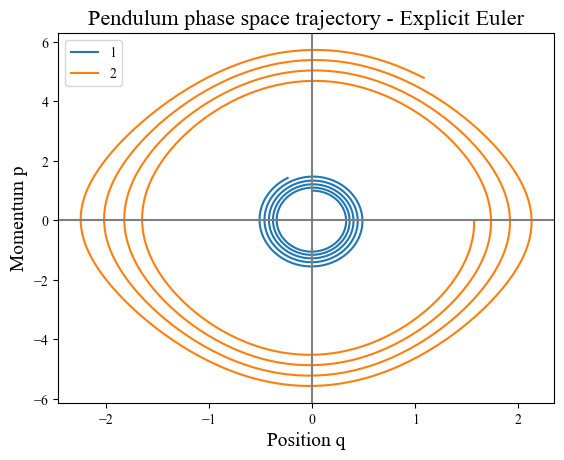

In [88]:
# Based on eurlers method in MCMC using hamiltonian dynamics
def explicit_euler(p, q, dt):
    p_next = p - dt * gradient_potenital_energy(q) # update position
    q_next = q + dt * p/m # update momentum
    return q_next, p_next

def generate_trajectory_euler(q0, p0):
    # Initialize the trajectory arrays
    t_euler = np.arange(0, t_max, dt_euler)
    q_euler = np.zeros_like(t_euler)
    p_euler = np.zeros_like(t_euler)

    # Set the initial values
    q_euler[0] = q0
    p_euler[0] = p0

    # Run the simulation using the Euler integrator
    for i in range(1, len(t_euler)):
        q_euler[i], p_euler[i] = explicit_euler(p_euler[i-1], q_euler[i-1], dt_euler)

    return q_euler, p_euler

#init_conditions_euler = [[np.pi/3, 0], [np.pi/2, 0], [np.pi, -3], [np.pi/2, 2], [0, 2], [2, 0], [-np.pi, 3], [3.1, 0]]
init_conditions_euler = [[0, 1], [np.pi/2, 0]]
q_euler = []
p_euler = []
legend_euler = []

for i in range(len(init_conditions_euler)):
    q, p = generate_trajectory_euler(init_conditions_euler[i][0], init_conditions_euler[i][1])
    q_euler.append(q)
    p_euler.append(p)

# Plot the trajectory in phase space
for i in range(len(q_euler)):
    plt.plot(q_euler[i], p_euler[i])
    legend_euler.append(str(i+1))

# Plot the trajectory in phase space
plt.xlabel('Position q', fontsize = 14)
plt.ylabel('Momentum p', fontsize = 14)
plt.axhline(y=0, color='grey')
plt.axvline(x=0, color='grey')
plt.legend(legend_euler, loc = "upper left" , frameon = True , prop ={'size': 10 } )
plt.title('Pendulum phase space trajectory - Explicit Euler', fontsize=16)
#plt.savefig(r"C:\Users\Heli\Documents\Master\tpk4960\src\hamilton_figures\pendulum_expliciteuler.eps", format ="eps")
plt.show()

In [89]:
def psi(x, w, b):
    m = 1
    J = np.block([[np.zeros((m,m)), np.identity(m)],
              [-np.identity(m), np.zeros((m,m))]])
    return J*np.cos(w.T@x + b)@w.T

""" def psi_vector(x, w, b, d):
    psi_vector = np.zeros(d)
    for i in range(d):
        x = x.reshape((-1,))
        psi_vector[i] = psi(x, w[:, i], b[:, i])
    return np.array(psi_vector) """

def capital_psi(x, w, b, d, dim):
    psi_vector_symplectic = np.zeros((d, dim))
    for i in range(d):
        psi_element = psi(x, w[:, i], b[:, i])
        psi_vector_symplectic[i] = psi_element
    return psi_vector_symplectic.T

def phi(x, w, b, n, d, dim):
    phi = np.zeros((dim*n, d))
    for i in range(n):
        psi = capital_psi(x[:, i], w, b, d, dim)
        phi[dim*i] = psi[0]
        phi[dim*i+1] = psi[1]
    return phi

def alpha_approx(x_vector, y, dim, d, lam, n):
    phi_ = phi(x_vector, w, b, n, d, dim)
    alpha_inv_part = np.linalg.inv(phi_.T @ phi_ + lam*np.eye(d))
    y_reshaped = np.array(np.ravel([y[0], y[1]], 'F'))
    alpha = alpha_inv_part @ (phi_.T @ y_reshaped)
    return alpha

In [109]:
q_leapfrog_tot = np.concatenate(q_leapfrog)
p_leapfrog_tot = np.concatenate(p_leapfrog)

[-2.80655855 -9.36279343]
[-2.70766727 -4.34742159]
[-2.58342522  3.36268036]
[-2.51020506  8.96957551]
[-2.53209213  9.11168063]
[-2.63483172  3.82019394]
[-2.7564819  -3.74056472]
[-2.8242072 -9.0990464]
[-2.79650008 -8.95371536]
[-2.68922472 -3.27961651]
[-2.56794325  4.42257801]
[-2.27102564 -9.09884439]
[-2.16836159 -3.63074021]
[-2.04404428  4.08839257]
[-1.97446511  9.25837001]
[-2.00142241  8.79204722]
[-2.10761752  3.08589796]
[-2.22908833 -4.4533367 ]
[-2.2930731  -9.36295473]
[-2.2602587  -8.60475058]
[-2.14964685 -2.53027194]
[-2.02889632  5.10820912]
[-1.73500772 -8.7766938 ]
[-1.62886237 -2.89083449]
[-1.50488128  4.78795301]
[-1.43921867  9.48794253]
[-1.47122135  8.41617472]
[-1.58056781  2.33186277]
[-1.70145738 -5.13762253]
[-1.76143991 -9.56697211]
[-1.72355865 -8.20074476]
[-1.6099341  -1.76474227]
[-1.49012169  5.76116512]
[-1.19852196 -8.39840231]
[-1.08920906 -2.1324373 ]
[-0.96597349  5.4568869 ]
[-0.90447799  9.65682459]
[-0.94146891  7.98646742]
[-1.0536424   

C:\Users\vilde\AppData\Local\Temp\ipykernel_12944\4165630640.py:46: RuntimeWarning: invalid value encountered in scalar divide
  u_norm[i, j] = u[i, j] / V_mod
C:\Users\vilde\AppData\Local\Temp\ipykernel_12944\4165630640.py:47: RuntimeWarning: invalid value encountered in scalar divide
  v_norm[i, j] = v[i, j] / V_mod
C:\Users\vilde\AppData\Local\Temp\ipykernel_12944\4165630640.py:61: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_hc.show()


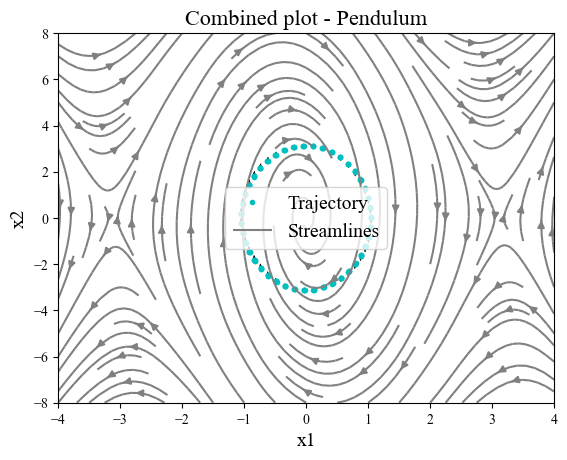

In [114]:
#x_train = np.array([q_leapfrog_tot[:100], p_leapfrog_tot[:100]])
x_train = np.array([q_leapfrog_tot, p_leapfrog_tot])
y_train = np.zeros_like(x_train)

time_series = np.arange(0, 100, dt_leap)

for i in range(len(x_train[0])):
    y_train[:, i] = hamiltonian_dynamics(0, x_train[:, i])
             
# Query only the length of the second dimension of x_train
num_of_points = x_train.shape[1]
dim_of_function = y_train.shape[0]

# Plot resulting trajectory in the data set and belonging streamlines
fig_dho_trajectory = plt.figure(5)
plt.title('Trajectory for Pendulum used in Regression problem', fontsize=16)
plt.plot(x_train[0, :], x_train[1, :], '.', linewidth=1)
plt.quiver(x_train[0, :], x_train[1, :], y_train[0, :], y_train[1, :])
plt.xlabel('q', fontsize=14)
plt.ylabel('p', fontsize=14)
plt.legend(['Trajectory', 'Velocities'], frameon = True , prop ={'size': 14 } )
plt.xlim([-5, 5])
plt.ylim([-7.5, 7.5])
fig_dho_trajectory.show()
#plt.savefig(r"C:\Users\Heli\Documents\Master\tpk4960\src\hamilton_figures\pendulum_trajectory_lf.eps", format ="eps") 

#### Teste noe

In [92]:
# Define the Leapfrog integrator
def leapfrog(q, p, dt):
    p_half = p - 0.5*dt*gradient_potenital_energy(q)
    q_next = q + dt*p_half
    p_next = p_half - 0.5*dt*gradient_potenital_energy(q_next)
    return np.array([q_next, p_next])

def generate_trajectory(q0, p0, t_max, dt_leap):
    # Initialize the trajectory arrays
    t_leapfrog = np.arange(0, t_max, dt_leap)
    #q_leapfrog = np.zeros_like(t_leapfrog)
    #p_leapfrog = np.zeros_like(t_leapfrog)
    x_leapfrog = np.zeros((2, len(t_leapfrog)))

    # Set the initial values
    q_leapfrog[0] = q0
    p_leapfrog[0] = p0
    x_leapfrog[:, 0] = np.array([q0, p0])

    # Run the simulation using the Leapfrog integrator
    for i in range(1, len(t_leapfrog)):
        #q_leapfrog[i], p_leapfrog[i] = leapfrog(q_leapfrog[i-1], p_leapfrog[i-1], dt_leap)
        x_leapfrog[:, i] = leapfrog(x_leapfrog[0, i-1], x_leapfrog[1, i-1], dt_leap)

    return x_leapfrog

In [102]:
size_of_state = 2
time_series = np.arange(0, 10, 0.001)
number_of_timesteps = len(time_series)

x_train = np.zeros((size_of_state, number_of_timesteps))
y_train = np.zeros_like(x_train)

start_state = np.array([2, -2])

x_train = generate_trajectory(start_state[0], start_state[1], 10, 0.001)

for i in range(len(x_train[0])):
    y_train[:, i] = hamiltonian_dynamics(0, x_train[:, i])

x_train_1 = np.zeros((size_of_state, number_of_timesteps))
y_train_1 = np.zeros_like(x_train_1)

x_train_1[:, 0] = np.array([2, -2])

for i in range(0, number_of_timesteps - 1):
    timespan = [time_series[i], time_series[i + 1]]
    start_state = x_train_1[:, i]

    # Sample dynamics at current time step
    y_train_1[:, i] = hamiltonian_dynamics(0, start_state)
    
    partial_trajectory = solve_ivp(hamiltonian_dynamics, timespan, start_state).y

    x_train_1[:, i+1] = partial_trajectory[:, -1]
    #print(x_train[:, i], ' og ',  x_train_1[:, i], '   og    ', y_train[:, i], ' og ', y_train_1[:, i])
    #print(y_train[:, i], ' og ', y_train_1[:, i])

C:\Users\vilde\AppData\Local\Temp\ipykernel_12944\3219760839.py:31: RuntimeWarning: invalid value encountered in scalar divide
  u_norm[i, j] = u[i, j] / V_mod
C:\Users\vilde\AppData\Local\Temp\ipykernel_12944\3219760839.py:32: RuntimeWarning: invalid value encountered in scalar divide
  v_norm[i, j] = v[i, j] / V_mod
C:\Users\vilde\AppData\Local\Temp\ipykernel_12944\3219760839.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_hc.show()


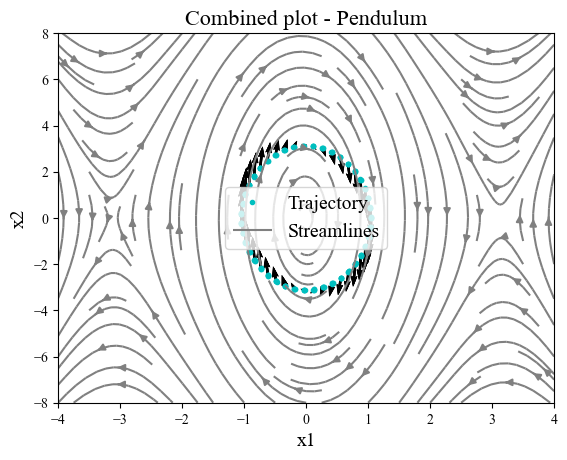

In [115]:
lower_bound_x1 = -4
upper_bound_x1 = 4
lower_bound_x2 = -8
upper_bound_x2 = 8

num_of_points = 11

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting points for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)

# Calculate df/dt for each point
t = 0

u = np.zeros(X1.shape)
v = np.zeros(X1.shape)
u_norm = np.zeros(X1.shape)
v_norm = np.zeros(X1.shape)

for (i, j), value in np.ndenumerate(X1):
    # get velocities at each point
    values = leapfrog(np.array([value, X2[i, j]])[0],  np.array([value, X2[i, j]])[1], 0.01)
    Y_prime = hamiltonian_dynamics(t, values)
    u[i, j] = Y_prime[0]
    v[i, j] = Y_prime[1]

    # normalize vector length
    V_mod = np.sqrt(u[i, j]**2 + v[i, j]**2)
    u_norm[i, j] = u[i, j] / V_mod
    v_norm[i, j] = v[i, j] / V_mod

# Plot resulting trajectory in the data set and belonging streamlines
# Combine solution and vector field
fig_hc = plt.figure(4)
plt.title('Combined plot - Pendulum', fontsize=16)
plt.plot(x_train[0, :], x_train[1, :], '.', linewidth=1, color='c')
plt.streamplot(X1, X2, u, v, density=1.1, color='gray')
plt.quiver(x_train[0, :], x_train[1, :], y_train[0, :], y_train[1, :])
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.legend(['Trajectory', 'Streamlines'], loc = "center" , frameon = True , prop ={'size': 14 } )
#plt.xlim([lower_bound_x1, upper_bound_x1])
#plt.ylim([lower_bound_x2, upper_bound_x2])
fig_hc.show()
#plt.savefig("../src/figures_plot/osc_ho.eps", format ="eps")

In [95]:
lower_bound_x1 = -20
upper_bound_x1 = 20
lower_bound_x2 = -30
upper_bound_x2 = 30

num_of_points = 11

x1 = np.linspace(lower_bound_x1, upper_bound_x1, num_of_points)
x2 = np.linspace(lower_bound_x2, upper_bound_x2, num_of_points)

# Base point or starting points for each vector of the vector field
[X1, X2] = np.meshgrid(x1, x2)
u_learnt = np.zeros(X1.shape)
v_learnt = np.zeros(X1.shape)

# for loop to get the velocity at each point witht the learnt model
for (i, j), value in np.ndenumerate(X1):
    Y_prime = learnt_model(t, np.array([value, X2[i, j]]))
    u_learnt[i, j] = Y_prime[0]
    v_learnt[i, j] = Y_prime[1]

# Plot simulated trajectory and streamslices for learnt model
fig_ho_w_rff = plt.figure(6)
plt.title('Combined plot - Learnt Pendulum model', fontsize=16)
plt.plot(data_series[0, :], data_series[1, :], '.', linewidth = 1)
plt.streamplot(X1, X2, u_learnt, v_learnt, density = 1.1, color ='gray')
plt.xlabel('x1', fontsize=14)
plt.ylabel('x2', fontsize=14)
plt.legend(['Trajectory', 'Streamlines'], frameon = True , prop ={'size': 14 } )
fig_ho_w_rff.show()
#plt.savefig(r"C:\Users\Heli\Documents\Master\tpk4960\src\hamilton_figures\pendulum_learned_model_lf.eps", format ="eps")

NameError: name 'learnt_model' is not defined